<ipython-input-8-354bef3ae6ac>:57: RuntimeWarning: overflow encountered in scalar power
  dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
<ipython-input-8-354bef3ae6ac>:58: RuntimeWarning: overflow encountered in scalar power
  dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
<ipython-input-8-354bef3ae6ac>:59: RuntimeWarning: overflow encountered in scalar power
  dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)
<ipython-input-8-354bef3ae6ac>:61: RuntimeWarning: overflow encountered in scalar power
  dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
<ipython-input-8-354bef3ae6ac>:62: RuntimeWarning: overflow encountered in scalar power
  dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
<ipython-input-8-354bef3ae6ac>:63: RuntimeWarning: overflow encountered in scalar power
  dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)
<ipython-input-8-354bef3ae6ac>:55: Runtim

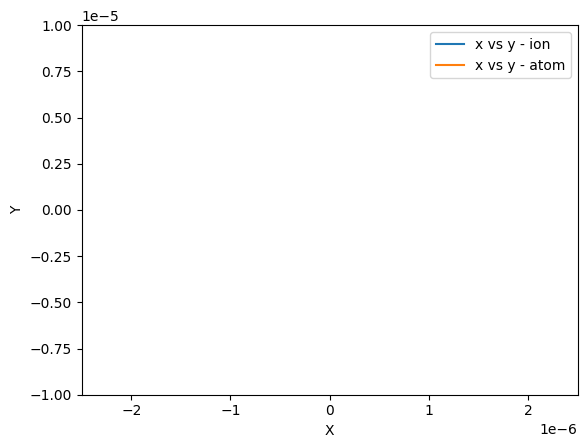

In [ ]:
#El código ya paralelizado
import numpy as np
import math
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525801E-25 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4  #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
Omega= 4.5*np.pi*10**6 #MHz
ax = -2.982E-4
ay = ax
az = -2*ax
qx = 0.2
qy = -0.2
qz = 0.0
T_ion = 0.1E-6  #0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6    #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0
tf= 10E-6   #o 10E-6
dt= 1000
num_solution = 1

def system(t, y):
    ionx, ionvx, atomx, atomvx, iony, ionvy, atomy, atomvy, ionz, ionvz, atomz, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(ax+2*qx*np.cos(Omega*t)) *ionx*(Omega**2 / 4)
    dydt[4] = -(ay+2*qy*np.cos(Omega*t)) *iony*(Omega**2 / 4)
    dydt[5] = -(2*az+2*-qz*np.cos(Omega*t)) *ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def velocidad_atom(temperature, mass, x, y, z):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Convertir a coordenadas cartesianas
    s = np.sqrt(x**2 + y**2 + z**2)

    if s == 0:
        raise ValueError("El vector de posición no puede ser el origen (0,0,0).")

    sin_theta = np.sin(np.arccos(z / s))
    cos_theta = z / s
    sin_phi = y / (s * sin_theta) if sin_theta != 0 else 0
    cos_phi = x / (s * sin_theta) if sin_theta != 0 else 1

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * sin_theta * cos_phi + v_theta * cos_theta * cos_phi - v_phi * sin_phi
    v_y = v_r * sin_theta * sin_phi + v_theta * cos_theta * sin_phi + v_phi * cos_phi
    v_z = v_r * cos_theta - v_theta * sin_theta

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

def position_on_sphere(radius):
    # Generar ángulos aleatorios en coordenadas esféricas
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):
    ionxi_0, ionyi_0, ionzi_0 = 0.0, 0.0, 0.0
    ionvxi_0=velocidad_ion(T_ion, m_ion)
    ionvyi_0= velocidad_ion(T_ion, m_ion)
    ionvzi_0=velocidad_ion(T_ion, m_ion)
    atomxi_0, atomyi_0, atomzi_0 = position_on_sphere(r0)
    atomvxi_0, atomvyi_0, atomvzi_0 = velocidad_atom(T_atom, m_atom, atomxi_0, atomyi_0, atomzi_0)
    initial_conditionsi = [ionxi_0, ionvxi_0, atomxi_0, atomvxi_0, ionyi_0, ionvyi_0, atomyi_0, atomvyi_0, ionzi_0, ionvzi_0, atomzi_0, atomvzi_0]

    solutioni = solve_ivp(system, t_span, initial_conditionsi, t_eval=np.linspace(t_span[0], t_span[1], dt))

    # Extracción de las soluciones temporales
    ionx_soli = solutioni.y[0]
    iony_soli = solutioni.y[1]
    ionz_soli = solutioni.y[2]
    ionvx_soli = solutioni.y[3]
    ionvy_soli = solutioni.y[4]
    ionvz_soli = solutioni.y[5]
    atomx_soli = solutioni.y[6]
    atomy_soli = solutioni.y[7]
    atomz_soli = solutioni.y[8]
    atomvx_soli = solutioni.y[9]
    atomvy_soli = solutioni.y[10]
    atomvz_soli = solutioni.y[11]

    return ionx_soli, iony_soli, ionz_soli, ionvx_soli, ionvy_soli, ionvz_soli, atomx_soli, atomy_soli, atomz_soli, atomvx_soli, atomvy_soli, atomvz_soli

if __name__ == '__main__':
    num_solution = 1
    num_cpus = cpu_count()
    with Pool(processes=num_cpus) as pool:
        results = pool.map(run_simulation, range(num_solution))

    for result in results:
        ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol = result
        plt.plot(ionx_sol, iony_sol, label='x vs y - ion')
        plt.plot(atomx_sol, atomy_sol, label='x vs y - atom')
        plt.xlim(-0.25E-5, 0.25E-5)
        plt.ylim(-1.0E-5, 1.0E-5)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.show()

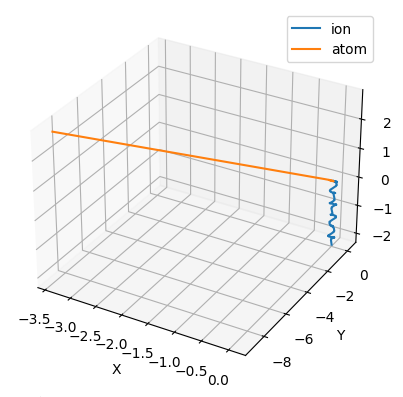

In [ ]:
#Grafico en 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar las trayectorias del ion y el átomo
ax.plot(ionx_sol, iony_sol, ionz_sol, label='ion')
ax.plot(atomx_sol, atomy_sol, atomz_sol, label='atom')

# Etiquetas de los ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Título del gráfico
#ax.set_title('Trayectorias del ion y el átomo en 3D')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


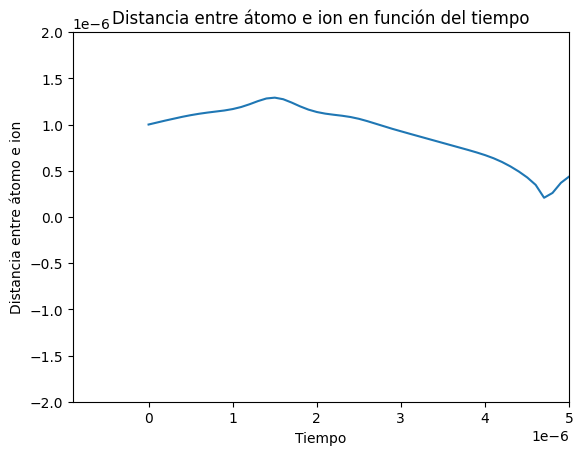

In [ ]:
# Calcular la distancia entre el átomo y el ion en cada paso de tiempo
distancia = np.sqrt((ionx_sol - atomx_sol)**2 + (iony_sol - atomy_sol)**2 + (ionz_sol - atomz_sol)**2)

# Graficar la distancia en función del tiempo
plt.xlim(-0.9E-6, 5.0E-6)
plt.ylim(-2E-6, 2E-6)
plt.plot(solution.t, distancia)
plt.xlabel('Tiempo')
plt.ylabel('Distancia entre átomo e ion')
plt.title('Distancia entre átomo e ion en función del tiempo')
plt.show()

atomvx_final -0.11449148145831409 atomvy_final 0.44407681367691887 atomvz_final -0.35873004301402767 atomvx_inicial -0.042858171763875935 atomvy_inicial 0.015120444413582786 atomvz_inicial 0.04087977955044357
ionvx_final -0.22383033690561643 ionvy_final 0.2331769055451325 ionvz_final 0.18999993795106798 ionvx_inicial -0.0016944449692873104 ionvy_inicial -0.002224939478912124 ionvz_inicial -0.012481029448503185
atomx_final -9.869170174236634e-06 atomy_final 3.6977832257532424e-05 atomy_final 3.6977832257532424e-05 atomx_inicial -4.072530193347364e-07 atomy_inicial -2.872283284592013e-07 atomz_inicial 6.258153606082819e-07
ionx_final -2.1114520153885816e-07 iony_final 2.0652271517986064e-07 ionz_final 1.608044376515097e-05 ionz_inicial 0.0 iony_inicial 0.0 ionz_inicial 0.0


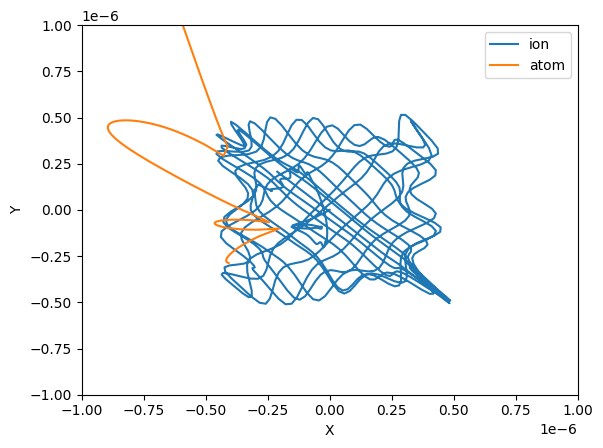

In [ ]:
#Codigo fijo que no debo cambiar, comportamiento esperado con las variables malas, a paralelizar estew, luego se arreglan las cosas
import numpy as np
import math
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D

m_ion = 2.83E-25
m_atom = 1.445E-25
C4=5.607E-45 #Li   C4=5.607E-57
C6=5.03E-15  #Li    C6=5.0E-19
Omega= 2*np.pi*1E6 #MHz
a = -7E-7   #-7E-8
q = 0.1

def system(t, y):
    ionx, ionvx, atomx, atomvx, iony, ionvy, atomy, atomvy, ionz, ionvz, atomz, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    # Ecuaciones para ionx y atomx
    dydt[0] = ionvx
    dydt[2] = atomvx

    # Ecuaciones para iony y atomy
    dydt[4] = ionvy
    dydt[6] = atomvy

    # Ecuaciones para ionz y atomz
    dydt[8] = ionvz
    dydt[10] = atomvz

    # Ecuaciones para ionvx, ionvy, ionvz
    dydt[1] = -a*ionx*(Omega**2 / 4)*-2*q*math.cos(Omega*t)*ionx*(-Omega**2 / 4) - (2*C4*(ionx-atomx))/ (m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(ionx-atomx))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[5] = -a*iony*(Omega**2 / 4)*-2*-q*math.cos(Omega*t)*iony*(-Omega**2 / 4) - (2*C4*(iony-atomy))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(iony-atomy))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[9] = (a/3)*ionz*(Omega**2 / 4) - (2*C4*(ionz-atomz))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(ionz-atomz))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)

    # Ecuaciones para atomvx, atomvy, atomvz
    dydt[3] = (2*C4*(ionx-atomx))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(ionx-atomx))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[7] = (2*C4*(iony - atomy))/(m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(iony-atomy))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[11] = (2*C4*(ionz - atomz))/(m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(ionz-atomz))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)

    return dydt

#Funciones
def velocidad_atom(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos

    # Velocidades en coordenadas esféricas
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)

    k_weibull = 2  # Parámetro de forma de la distribución Weibull
    scale_weibull = np.sqrt(2 * kb * temperature / mass)  # Parámetro de escala de la Weibull
    v_r = (np.random.weibull(k_weibull) * scale_weibull)  # Velocidad radial con valor absoluto

    # Transformación de coordenadas esféricas a cartesianas
    v_x = v_r * np.sin(v_theta) * np.cos(v_phi) + v_theta * np.cos(v_theta) * np.cos(v_phi) - v_phi * np.sin(v_phi)
    v_y = v_r * np.sin(v_theta) * np.sin(v_phi) + v_theta * np.cos(v_theta) * np.sin(v_phi) + v_phi * np.cos(v_phi)
    v_z = v_r * np.cos(v_theta) - v_theta * np.sin(v_theta)

    return v_x, v_y, v_z

def velocidad_maxwell_boltzmann(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

def position_on_sphere(radius):
    #while True:
        # Generar ángulos aleatorios en coordenadas esféricas
        phi = 2 * np.pi * np.random.rand()
        theta = np.arccos(2 * np.random.rand() - 1)
        x = radius * np.sin(theta) * np.cos(phi)
        y = radius * np.sin(theta) * np.sin(phi)
        z = radius * np.cos(theta)
        # Comprobar si ninguna de las coordenadas es igual a cero
        #if x != 0 and y != 0 and z != 0:
        return x, y, z

ionx_0=0.0
iony_0=0.0
ionz_0=0.0
ionvx_0=velocidad_maxwell_boltzmann(0.5E-6, 2.83E-25 )  #Temperatura, masa Yb+ 0.5E-3. 6E-6
ionvy_0= velocidad_maxwell_boltzmann(0.5E-6, 2.83E-25 )
ionvz_0=velocidad_maxwell_boltzmann(0.5E-6, 2.83E-25)
atomx_0, atomy_0, atomz_0 = position_on_sphere(0.8E-6)
#atomx_0, atomy_0, atomz_0 = 7.432586614996262e-08 , 1.1020322864139567e-06 , -4.690421146573991e-07
#ionvx_0, ionvy_0, ionvz_0 = 0.04650059993418737, 0.028331953233529217, 0.028331953233529217
#atomvx_0, atomvy_0, atomvz_0 = -0.04650059993418737, -0.028331953233529217, -0.028331953233529217
atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(6E-6, 1.4453E-25) #6µK, 0.5mK Ziv Meir

initial_conditions = [ionx_0, ionvx_0, atomx_0, atomvx_0, iony_0, ionvy_0, atomy_0, atomvy_0, ionz_0, ionvz_0, atomz_0, atomvz_0]

# Definición del vector de tiempo
t_span = (0, 0.0001)  # Desde t=0 hasta t=10

# Resolución del sistema de ecuaciones diferenciales
solution = solve_ivp(system, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 1000))

# Extracción de las soluciones temporales
ionx_sol = solution.y[0]
ionvx_sol = solution.y[1]
atomx_sol = solution.y[2]
atomvx_sol = solution.y[3]
iony_sol = solution.y[4]
ionvy_sol = solution.y[5]
atomy_sol = solution.y[6]
atomvy_sol = solution.y[7]
ionz_sol = solution.y[8]
ionvz_sol = solution.y[9]
atomz_sol = solution.y[10]
atomvz_sol = solution.y[11]


# Graficar las soluciones
#plt.plot(ionx_sol, iony_sol, label='ionx vs iony')
#plt.plot(atomx_sol, atomy_sol, label='ionx vs iony')
#print("Solución de ionx:",ionx_sol)
#print("Solución de iony:", iony_sol)
#print("Tiempo:", solution.t)
#fin = 10000
plt.plot(ionx_sol, iony_sol, label='ion')
plt.plot(atomx_sol, atomy_sol, label='atom')
#Constantes bajo las cuales la simulación tiene sentido
print('atomvx_final',atomvx_sol[-1], 'atomvy_final',atomvy_sol[-1], 'atomvz_final',atomvz_sol[-1], 'atomvx_inicial',atomvx_sol[0], 'atomvy_inicial', atomvy_sol[0], 'atomvz_inicial', atomvz_sol[0])
print('ionvx_final',ionvx_sol[-1], 'ionvy_final',ionvy_sol[-1], 'ionvz_final',ionvz_sol[-1], 'ionvx_inicial',ionvx_sol[0], 'ionvy_inicial', ionvy_sol[0], 'ionvz_inicial', ionvz_sol[0])
print('atomx_final',atomx_sol[-1], 'atomy_final',atomy_sol[-1], 'atomy_final',atomy_sol[-1], 'atomx_inicial',atomx_sol[0], 'atomy_inicial', atomy_sol[0], 'atomz_inicial', atomz_sol[0])
print('ionx_final',ionx_sol[-1], 'iony_final',iony_sol[-1], 'ionz_final',ionz_sol[-1], 'ionz_inicial',ionz_sol[0], 'iony_inicial', iony_sol[0], 'ionz_inicial', ionz_sol[0])


plt.xlim(-1.0E-6, 1.0E-6)
plt.ylim(-1E-6, 1E-6)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

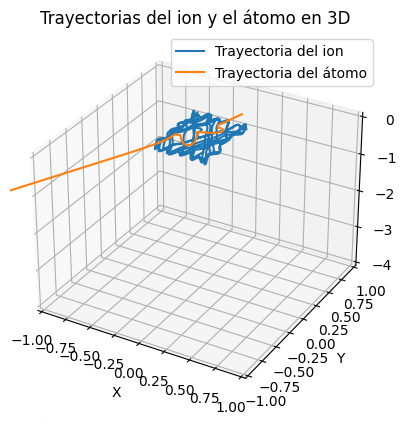

In [ ]:
#Grafico en 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar las trayectorias del ion y el átomo
ax.plot(ionx_sol, iony_sol, ionz_sol, label='Trayectoria del ion')
ax.plot(atomx_sol, atomy_sol, atomz_sol, label='Trayectoria del átomo')

# Etiquetas de los ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Título del gráfico
ax.set_title('Trayectorias del ion y el átomo en 3D')

# Mostrar la leyenda
plt.legend()
plt.xlim(-1.0E-6, 1.0E-6)
plt.ylim(-1E-6, 1E-6)

# Mostrar el gráfico
plt.show()

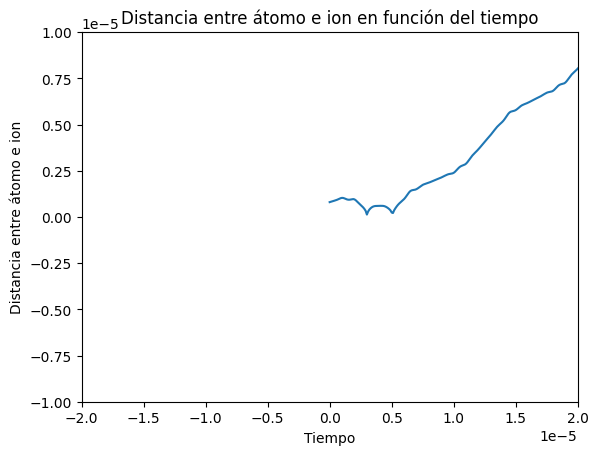

In [ ]:
# Calcular la distancia entre el átomo y el ion en cada paso de tiempo
distancia = np.sqrt((ionx_sol - atomx_sol)**2 + (iony_sol - atomy_sol)**2 + (ionz_sol - atomz_sol)**2)
plt.xlim(-0.00002, 0.00002)
plt.ylim(-1E-5, 1E-5)
# Graficar la distancia en función del tiempo
plt.plot(solution.t, distancia)
plt.xlabel('Tiempo')
plt.ylabel('Distancia entre átomo e ion')
plt.title('Distancia entre átomo e ion en función del tiempo')
plt.show()

atomvx_final -0.41933967191976906 atomvy_final -0.5649447589634918 atomvz_final 0.6593710520466562 atomvx_inicial 0.07937475502672733 atomvy_inicial -0.09213931579854429 atomvz_inicial -0.011990275137605576
ionvx_final 0.0822757882803406 ionvy_final 0.20464398013024998 ionvz_final -0.11640634204870172 ionvx_inicial -0.22733816019100503 ionvy_inicial 0.25819468930862094 ionvz_inicial 0.15173554784915502
atomx_final -3.494475383359713e-05 atomy_final -4.738164170567392e-05 atomz_final 5.6049091865952675e-05 atomx_inicial -8.347064802302461e-07 atomy_inicial -3.396480850457276e-07 atomz_inicial -4.3347926154131526e-07
ionx_final 2.237940743609144e-07 iony_final 3.5795381160040364e-07 ionz_final -7.903369979357083e-06 ionx_inicial 0.0 iony_inicial 0.0 ionz_inicial 0.0


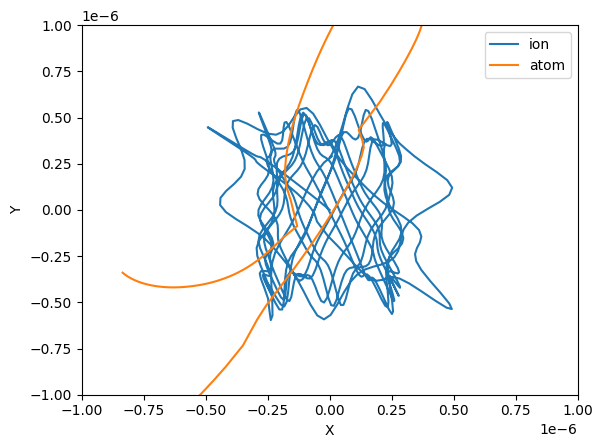

In [ ]:
#Código para experimentar, al que le puedo cambiar las variables
#Optimizado
import numpy as np
import math
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import random

m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.15E-25 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 ) Influencia de atomo pesado o liviano
C4=5.607E-45   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=2.83E-15      #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
Omega= 2*np.pi*1E6 #MHz
a = -7E-7   #No deberia afectar mucho, me lo recomendó Mateo
q = 0.1      #Entre 0.1 y otro
T_ion = 0.5E-3  #0.5 milikelvin   Paper Ziv Meir (de Jesus)  10 microK para ambos en jesus
T_atom = 6E-6    #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 1.0E-6   #Influencia de la distancia
ti= 0         #Influencia del tiempo
tf= 0.0001
dt= 1000

def system(t, y):
    ionx, ionvx, atomx, atomvx, iony, ionvy, atomy, atomvy, ionz, ionvz, atomz, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    # Ecuaciones para ionx y atomx
    dydt[0] = ionvx
    dydt[2] = atomvx

    # Ecuaciones para iony y atomy
    dydt[4] = ionvy
    dydt[6] = atomvy

    # Ecuaciones para ionz y atomz
    dydt[8] = ionvz
    dydt[10] = atomvz

    # Ecuaciones para ionvx, ionvy, ionvz
    dydt[1] = -a*ionx*(Omega**2 / 4)*-2*q*math.cos(Omega*t)*ionx*(-Omega**2 / 4) - (2*C4*(ionx-atomx))/ (m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(ionx-atomx))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[5] = -a*iony*(Omega**2 / 4)*-2*-q*math.cos(Omega*t)*iony*(-Omega**2 / 4) - (2*C4*(iony-atomy))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(iony-atomy))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[9] = (a/3)*ionz*(Omega**2 / 4) - (2*C4*(ionz-atomz))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(ionz-atomz))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)

    # Ecuaciones para atomvx, atomvy, atomvz
    dydt[3] = (2*C4*(ionx-atomx))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(ionx-atomx))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[7] = (2*C4*(iony - atomy))/(m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(iony-atomy))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[11] = (2*C4*(ionz - atomz))/(m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(ionz-atomz))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)

    return dydt

# Funciones
def velocidad_atom(temperature, mass, x, y, z):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Convertir a coordenadas cartesianas
    s = np.sqrt(x**2 + y**2 + z**2)

    if s == 0:
        raise ValueError("El vector de posición no puede ser el origen (0,0,0).")

    sin_theta = np.sin(np.arccos(z / s))
    cos_theta = z / s
    sin_phi = y / (s * sin_theta) if sin_theta != 0 else 0
    cos_phi = x / (s * sin_theta) if sin_theta != 0 else 1

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * sin_theta * cos_phi + v_theta * cos_theta * cos_phi - v_phi * sin_phi
    v_y = v_r * sin_theta * sin_phi + v_theta * cos_theta * sin_phi + v_phi * cos_phi
    v_z = v_r * cos_theta - v_theta * sin_theta

    return v_x, v_y, v_z

def velocidad_maxwell_boltzmann(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

def position_on_sphere(radius):
    # Generar ángulos aleatorios en coordenadas esféricas
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

# Condiciones iniciales
ionx_0 = 0.0
iony_0 = 0.0
ionz_0 = 0.0
ionvx_0 = velocidad_maxwell_boltzmann(T_ion, m_ion)  # Temperatura, masa Yb+ 0.5E-3. 6E-6
ionvy_0 = velocidad_maxwell_boltzmann(T_ion, m_ion)
ionvz_0 = velocidad_maxwell_boltzmann(T_ion, m_ion)
atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)  # 6µK, 0.5mK Ziv Meir

initial_conditions = [ionx_0, ionvx_0, atomx_0, atomvx_0, iony_0, ionvy_0, atomy_0, atomvy_0, ionz_0, ionvz_0, atomz_0, atomvz_0]

# Definición del vector de tiempo
t_span = (ti, tf)  # Desde t=0 hasta t=10

# Resolución del sistema de ecuaciones diferenciales
solution = solve_ivp(system, t_span, initial_conditions, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))

# Extracción de las soluciones temporales
ionx_sol = solution.y[0]
ionvx_sol = solution.y[1]
atomx_sol = solution.y[2]
atomvx_sol = solution.y[3]
iony_sol = solution.y[4]
ionvy_sol = solution.y[5]
atomy_sol = solution.y[6]
atomvy_sol = solution.y[7]
ionz_sol = solution.y[8]
ionvz_sol = solution.y[9]
atomz_sol = solution.y[10]
atomvz_sol = solution.y[11]

# Graficar las soluciones
plt.plot(ionx_sol, iony_sol, label='ion')
plt.plot(atomx_sol, atomy_sol, label='atom')

print('atomvx_final', atomvx_sol[-1], 'atomvy_final', atomvy_sol[-1], 'atomvz_final', atomvz_sol[-1],
      'atomvx_inicial', atomvx_sol[0], 'atomvy_inicial', atomvy_sol[0], 'atomvz_inicial', atomvz_sol[0])
print('ionvx_final', ionvx_sol[-1], 'ionvy_final', ionvy_sol[-1], 'ionvz_final', ionvz_sol[-1],
      'ionvx_inicial', ionvx_sol[0], 'ionvy_inicial', ionvy_sol[0], 'ionvz_inicial', ionvz_sol[0])
print('atomx_final', atomx_sol[-1], 'atomy_final', atomy_sol[-1], 'atomz_final', atomz_sol[-1],
      'atomx_inicial', atomx_sol[0], 'atomy_inicial', atomy_sol[0], 'atomz_inicial', atomz_sol[0])
print('ionx_final', ionx_sol[-1], 'iony_final', iony_sol[-1], 'ionz_final', ionz_sol[-1],
      'ionx_inicial', ionx_sol[0], 'iony_inicial', iony_sol[0], 'ionz_inicial', ionz_sol[0])

plt.xlim(-1.0E-6, 1.0E-6)
plt.ylim(-1E-6, 1E-6)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
#Ver regiones de estabilidad de q y a
import numpy as np
import math
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import random

m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.15E-25 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 ) Influencia de atomo pesado o liviano
C4=5.607E-45   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=2.83E-15      #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
Omega= 2*np.pi*1E6 #MHz
a = -7E-7   #No deberia afectar mucho, me lo recomendó Mateo
q = 0.1      #Entre 0.1 y otro
T_ion = 0.5E-3  #0.5 milikelvin   Paper Ziv Meir (de Jesus)  10 microK para ambos en jesus
T_atom = 6E-6    #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 1.0E-6   #Influencia de la distancia
ti= 0         #Influencia del tiempo
tf= 0.0001
dt= 1000

def system(t, y):
    ionx, ionvx, atomx, atomvx, iony, ionvy, atomy, atomvy, ionz, ionvz, atomz, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    # Ecuaciones para ionx y atomx
    dydt[0] = ionvx
    dydt[2] = atomvx

    # Ecuaciones para iony y atomy
    dydt[4] = ionvy
    dydt[6] = atomvy

    # Ecuaciones para ionz y atomz
    dydt[8] = ionvz
    dydt[10] = atomvz

    # Ecuaciones para ionvx, ionvy, ionvz
    dydt[1] = -a*ionx*(Omega**2 / 4)*-2*q*math.cos(Omega*t)*ionx*(-Omega**2 / 4) - (2*C4*(ionx-atomx))/ (m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(ionx-atomx))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[5] = -a*iony*(Omega**2 / 4)*-2*-q*math.cos(Omega*t)*iony*(-Omega**2 / 4) - (2*C4*(iony-atomy))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(iony-atomy))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[9] = (a/3)*ionz*(Omega**2 / 4) - (2*C4*(ionz-atomz))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) + (6*C4*C6*(ionz-atomz))/(m_ion*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)

    # Ecuaciones para atomvx, atomvy, atomvz
    dydt[3] = (2*C4*(ionx-atomx))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(ionx-atomx))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[7] = (2*C4*(iony - atomy))/(m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(iony-atomy))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)
    dydt[11] = (2*C4*(ionz - atomz))/(m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**5) - (6*C4*C6*(ionz-atomz))/ (m_atom*np.sqrt((ionx - atomx) ** 2 + (iony - atomy) ** 2 + (ionz - atomz) ** 2)**7)

    return dydt

# Funciones
def velocidad_atom(temperature, mass, x, y, z):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Convertir a coordenadas cartesianas
    s = np.sqrt(x**2 + y**2 + z**2)

    if s == 0:
        raise ValueError("El vector de posición no puede ser el origen (0,0,0).")

    sin_theta = np.sin(np.arccos(z / s))
    cos_theta = z / s
    sin_phi = y / (s * sin_theta) if sin_theta != 0 else 0
    cos_phi = x / (s * sin_theta) if sin_theta != 0 else 1

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * sin_theta * cos_phi + v_theta * cos_theta * cos_phi - v_phi * sin_phi
    v_y = v_r * sin_theta * sin_phi + v_theta * cos_theta * sin_phi + v_phi * cos_phi
    v_z = v_r * cos_theta - v_theta * sin_theta

    return v_x, v_y, v_z

def velocidad_maxwell_boltzmann(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

def position_on_sphere(radius):
    # Generar ángulos aleatorios en coordenadas esféricas
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

# Condiciones iniciales
ionx_0 = 0.0
iony_0 = 0.0
ionz_0 = 0.0
ionvx_0 = velocidad_maxwell_boltzmann(T_ion, m_ion)  # Temperatura, masa Yb+ 0.5E-3. 6E-6
ionvy_0 = velocidad_maxwell_boltzmann(T_ion, m_ion)
ionvz_0 = velocidad_maxwell_boltzmann(T_ion, m_ion)
atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)  # 6µK, 0.5mK Ziv Meir

initial_conditions = [ionx_0, ionvx_0, atomx_0, atomvx_0, iony_0, ionvy_0, atomy_0, atomvy_0, ionz_0, ionvz_0, atomz_0, atomvz_0]

# Definición del vector de tiempo
t_span = (ti, tf)  # Desde t=0 hasta t=10

# Resolución del sistema de ecuaciones diferenciales
solution = solve_ivp(system, t_span, initial_conditions, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))

# Extracción de las soluciones temporales
ionx_sol = solution.y[0]
ionvx_sol = solution.y[1]
atomx_sol = solution.y[2]
atomvx_sol = solution.y[3]
iony_sol = solution.y[4]
ionvy_sol = solution.y[5]
atomy_sol = solution.y[6]
atomvy_sol = solution.y[7]
ionz_sol = solution.y[8]
ionvz_sol = solution.y[9]
atomz_sol = solution.y[10]
atomvz_sol = solution.y[11]



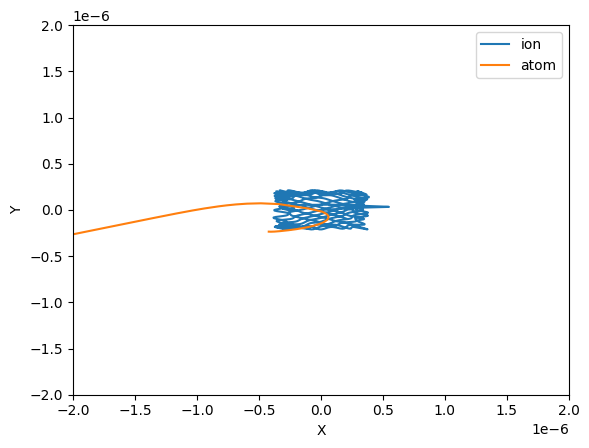

In [ ]:
# Graficar las soluciones
plt.plot(ionx_sol, iony_sol, label='ion')
plt.plot(atomx_sol, atomy_sol, label='atom')
plt.xlim(-2.0E-6, 2.0E-6)
plt.ylim(-2E-6, 2E-6)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

atomvx_final -0.3482304973147059 atomvy_final -0.09495348436337926 atomvz_final 0.30642870186580445 atomvx_inicial 0.053728960095110814 atomvy_inicial -0.005637088125886477 atomvz_inicial -0.00702431996345507
ionvx_final 0.17337394388699456 ionvy_final -0.06445133576865765 ionvz_final -0.23145296383714645 ionvx_inicial 0.3530303198057403 ionvy_inicial 0.02675912285943998 ionvz_inicial -0.10845297193524862
atomx_final -3.3926986300741376e-05 atomy_final -8.969559327294238e-06 atomz_final 2.8860082306173915e-05 atomx_inicial -4.205564192037533e-07 atomy_inicial -2.3504690799621107e-07 atomz_inicial 8.762906192057162e-07
ionx_final 2.0965912077749665e-07 iony_final -9.637128239524056e-08 ionz_final -2.2248035396801522e-05 ionx_inicial 0.0 iony_inicial 0.0 ionz_inicial 0.0


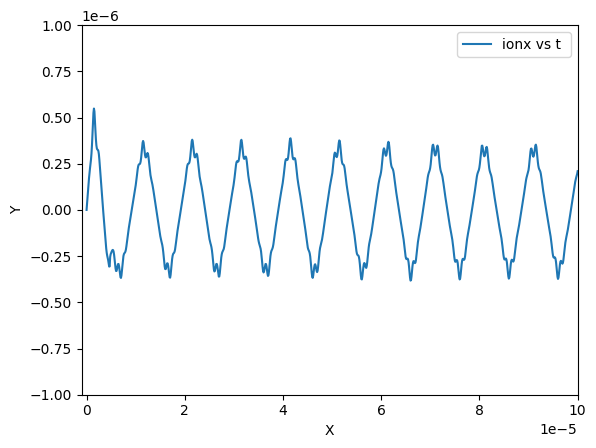

In [ ]:
# Graficar las soluciones
#plt.plot(ionx_sol, iony_sol, label='ion')
#plt.plot(atomx_sol, atomy_sol, label='atom')
plt.plot(solution.t, ionx_sol, label='ionx vs t ')


print('atomvx_final', atomvx_sol[-1], 'atomvy_final', atomvy_sol[-1], 'atomvz_final', atomvz_sol[-1],
      'atomvx_inicial', atomvx_sol[0], 'atomvy_inicial', atomvy_sol[0], 'atomvz_inicial', atomvz_sol[0])
print('ionvx_final', ionvx_sol[-1], 'ionvy_final', ionvy_sol[-1], 'ionvz_final', ionvz_sol[-1],
      'ionvx_inicial', ionvx_sol[0], 'ionvy_inicial', ionvy_sol[0], 'ionvz_inicial', ionvz_sol[0])
print('atomx_final', atomx_sol[-1], 'atomy_final', atomy_sol[-1], 'atomz_final', atomz_sol[-1],
      'atomx_inicial', atomx_sol[0], 'atomy_inicial', atomy_sol[0], 'atomz_inicial', atomz_sol[0])
print('ionx_final', ionx_sol[-1], 'iony_final', iony_sol[-1], 'ionz_final', ionz_sol[-1],
      'ionx_inicial', ionx_sol[0], 'iony_inicial', iony_sol[0], 'ionz_inicial', ionz_sol[0])

plt.xlim(-1.0E-6, 1.0E-4)
plt.ylim(-1E-6, 1E-6)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

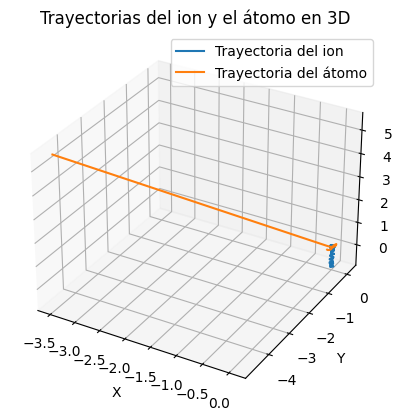

In [ ]:
#Grafico en 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Graficar las trayectorias del ion y el átomo
ax.plot(ionx_sol, iony_sol, ionz_sol, label='Trayectoria del ion')
ax.plot(atomx_sol, atomy_sol, atomz_sol, label='Trayectoria del átomo')

# Etiquetas de los ejes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Título del gráfico
ax.set_title('Trayectorias del ion y el átomo en 3D')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

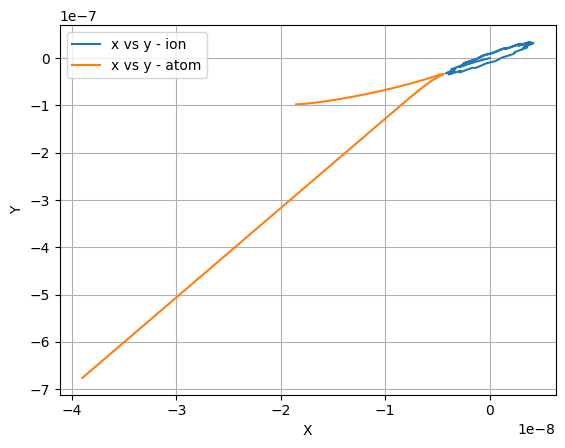

In [ ]:
#Borrador de mi codigo con correciones
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525801E-25 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.2      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0
tf= 10E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6;
dt= 1000
num_solution = 1
phi = 2 * np.pi * np.random.rand()
theta = np.arccos(2 * np.random.rand() - 1)
ptol = 1e-10

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t)) *ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t)) *iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t)) *ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    #v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = abs(v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi))
    v_y = abs(v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi))
    v_z = abs(v_r * np.cos(theta) - v_theta * np.sin(theta))

    #Asegurar que apuntan al centro
    r = np.sqrt(x**2 + y**2 + z**2)
    vx = (-x / r) * v_x
    vy = (-y / r) * v_y
    vz = (-z / r) * v_z

    return vx, vy, vz

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):
    ionxi_0=0.0
    ionyi_0=0.0
    ionzi_0=0.0
    ionvxi_0=velocidad_ion(T_ion, m_ion)
    ionvyi_0= velocidad_ion(T_ion, m_ion)
    ionvzi_0=velocidad_ion(T_ion, m_ion)
    atomxi_0, atomyi_0, atomzi_0 = position_on_sphere(r0)
    atomvxi_0, atomvyi_0, atomvzi_0 = velocidad_atom(T_atom, m_atom, atomxi_0, atomyi_0, atomzi_0)
    y0 = [ionxi_0, ionyi_0, ionzi_0, ionvxi_0, ionvyi_0, ionvzi_0, atomxi_0, atomyi_0, atomzi_0, atomvxi_0, atomvyi_0, atomvzi_0]

    #solution = solve_ivp( f, t_span, y0, t_eval=t_eval, method='RK45',  args=(ax, ay, az, qx, qy, qz, OmegaRF, C4, C6, mion, ma), rtol=ptol)
    solutioni = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol )

    # Extracción de las soluciones temporales
    ionx_soli = solutioni.y[0]
    iony_soli = solutioni.y[1]
    ionz_soli = solutioni.y[2]
    ionvx_soli = solutioni.y[3]
    ionvy_soli = solutioni.y[4]
    ionvz_soli = solutioni.y[5]
    atomx_soli = solutioni.y[6]
    atomy_soli = solutioni.y[7]
    atomz_soli = solutioni.y[8]
    atomvx_soli = solutioni.y[9]
    atomvy_soli = solutioni.y[10]
    atomvz_soli = solutioni.y[11]

    return ionx_soli, iony_soli, ionz_soli, ionvx_soli, ionvy_soli, ionvz_soli, atomx_soli, atomy_soli, atomz_soli, atomvx_soli, atomvy_soli, atomvz_soli

if __name__ == '__main__':
    num_solution = 1
    num_cpus = cpu_count()
    with Pool(processes=num_cpus) as pool:
        results = pool.map(run_simulation, range(num_solution))

    for result in results:
        ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol = result

        plt.plot(ionx_sol, iony_sol, label='x vs y - ion')

        plt.plot(atomx_sol, atomy_sol, label='x vs y - atom')



        plt.xlabel('X')
        plt.ylabel('Y')
        plt.legend()
        plt.grid()
        plt.show()

In [ ]:
#Debe graficarse en relación al tiempo
R = []
for i in range(1000):
  R.append(np.sqrt((atomx_sol[i] - ionx_sol[i])**2 + (atomy_sol[i] - iony_sol[i])**2 + (atomz_sol[i] - ionz_sol[i])**2))


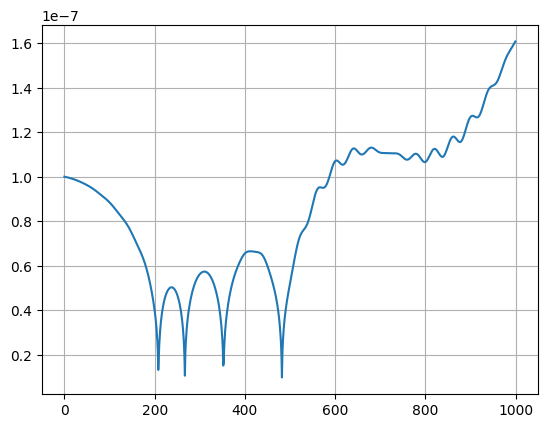

In [ ]:

plt.plot(R)
plt.grid()

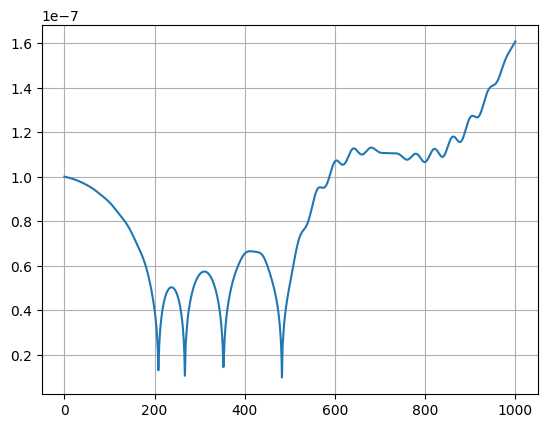

In [ ]:
from scipy.interpolate import CubicSpline
x_grid = np.linspace(0,1000,1000)
R_t = CubicSpline(x_grid,R)
x_grid2 = np.linspace(0,1000,1000000)
R2 = R_t(x_grid2)
plt.plot(x_grid2, R2)
plt.grid()

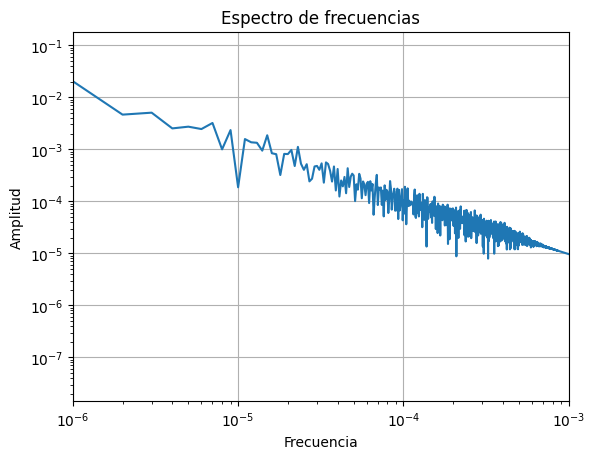

In [ ]:
#AAplicación FFT
N = len(R2)
y_fft= np.fft.fft(R2)
x_fft= np.fft.fftfreq(len(R2))[:N//2]

#Graficas en dominio de frecuencias
plt.plot(x_fft, np.abs(y_fft[:N//2]))
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1e-3)
plt.xlabel('Frecuencia')
plt.ylabel('Amplitud')
plt.title('Espectro de frecuencias')
plt.grid()
plt.show()